<a href="https://www.kaggle.com/code/salilapte/image-caption-cnn-generator?scriptVersionId=235975338" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Project Initialization and Environment Setup

This notebook initializes the deep learning environment using **PyTorch**, with additional support for image processing (`torchvision`, `PIL`) and natural language processing (`nltk`, `sklearn`). It supports both **CPU and GPU execution**, depending on availability.

---

**Library Overview:**

| Library | Purpose |
|--------|---------|
| `torch`, `torch.nn`, `torch.optim` | Building, training, and optimizing neural networks |
| `torchvision` | Pre-trained models and image transformations |
| `PIL.Image` | Opening and manipulating image files |
| `matplotlib.pyplot` | Visualization of results (loss curves, sample images, etc.) |
| `os`, `pandas`, `random`, `collections` | Data manipulation and utility functions |
| `nltk` | Tokenization and preprocessing for text data |
| `sklearn.feature_extraction.text.TfidfVectorizer` | Text vectorization using TF-IDF |
| `numpy` | Efficient numerical operations |

---

### Downloading NLTK Resources


This ensures `nltk` can perform word tokenization. The Punkt tokenizer is a pre-trained model for sentence and word splitting.



### Configuring the Device


This selects **GPU (CUDA)** if available for faster training, otherwise defaults to **CPU**.


**Sample Output:**
```
Using device: cuda
```
or
```
Using device: cpu
```

---

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
nltk.download('punkt')

# ----------------------------
# 1. Device Configuration
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda


---

## CNN Feature Extractor with ResNet50

In this section, we define a **Convolutional Neural Network (CNN)**-based feature extractor that leverages the power of **ResNet50**, a deep residual network pre-trained on ImageNet.

### Key Components:

- **Pretrained ResNet50**: Utilizes a pre-trained `ResNet50` model from `torchvision.models`. This allows us to benefit from transfer learning by extracting rich image features from lower layers of a network already trained on a massive dataset.

- **Feature Truncation**: The final fully connected (classification) layer is removed so that only feature maps are retained. This results in high-level visual features rather than class predictions.

- **Custom Fully Connected Layer**: A new fully connected (`Linear`) layer is added to project the 2048-dimensional output of ResNet into a 512-dimensional feature space, making it more compact for downstream tasks (e.g., text-image fusion).

- **Gradient-Free Forward Pass**: The ResNet backbone is frozen using `torch.no_grad()` to avoid unnecessary gradient computations during forward propagation. This is useful for inference and when the CNN is used purely as a feature encoder.

---

This module forms the **vision backbone** of the system, converting raw images into vector embeddings that can be used in multimodal architectures such as image-text matching or caption generation.


In [2]:
# ----------------------------
# 2. CNN Feature Extractor (ResNet50)
# ----------------------------
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # remove final FC layer
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, 512)

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)  # [B, 2048, 1, 1]
            features = features.view(features.size(0), -1)
        return self.fc(features)

---

## Transformer-Based Caption Generator

This section defines the **Transformer Decoder architecture** used for generating captions from image features. It serves as the **language head** of the model and processes both learned visual embeddings and partial text sequences to predict the next word in a caption.

### Key Components:

- **Embedding Layer**:
  - Converts input word indices (captions) into dense vector representations.
  - Embedding size is aligned with the `hidden_size` used across the Transformer.

- **Positional Encoding**:
  - A learnable parameter that injects positional information into the embedded tokens.
  - Helps the Transformer understand the order of words in a sequence.

- **Transformer Decoder**:
  - Composed of multiple stacked layers (configurable via `num_layers`), each with multi-head self-attention (`num_heads`) and feed-forward sublayers.
  - Utilizes PyTorch’s `nn.TransformerDecoder` for autoregressive decoding.
  - Takes **image features** as memory input and **embedded captions** as target input.

- **Target Masking**:
  - Uses a square subsequent mask to prevent the model from peeking ahead during training, ensuring autoregressive behavior in caption generation.

- **Final Output Layer**:
  - Projects the decoded representation into vocabulary space to predict the next word token.

---

This Transformer decoder enables **context-aware captioning**, allowing the model to generate coherent textual descriptions based on visual features and previously generated tokens. It's a powerful alternative to traditional RNNs or LSTMs, offering better parallelization and long-range dependency handling.


In [3]:
# ----------------------------
# 3. Transformer Decoder for Captioning
# ----------------------------
class CaptionGenerator(nn.Module):
    def __init__(self, feature_size=512, hidden_size=512, vocab_size=2002, num_layers=2, num_heads=8):
        super(CaptionGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 50, hidden_size))
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads), num_layers
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        captions = torch.clamp(captions, min=0, max=2001)
        captions = self.embedding(captions) + self.pos_encoder[:, :captions.size(1), :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(captions.size(1)).to(captions.device)
        output = self.transformer_decoder(captions.permute(1, 0, 2), features.unsqueeze(0), tgt_mask).permute(1, 0, 2)
        return self.fc(output)

---

## Custom Dataset: Flickr8k Image-Caption Pairing

This section defines a PyTorch-compatible dataset class for the **Flickr8k** dataset, which contains 8,000 images paired with multiple human-written captions. The dataset is used for training and evaluating image captioning models.

### Dataset Structure:

- **Images Directory**: Folder containing `.jpg` image files.
- **Captions CSV**: A file mapping image filenames to multiple textual captions. Each row typically contains:
  ```
  image_name, caption_text
  ```

### Dataset Construction Highlights:

- **Image Selection**:
  - For performance considerations, the dataset restricts loading to the first 4,000 unique images (customizable).

- **Caption Dictionary**:
  - For each image, all associated captions are stored in a dictionary for efficient access.

- **Vocabulary Building**:
  - Captions are tokenized using NLTK’s `word_tokenize`.
  - The top 2000 most frequent words are selected to create a vocabulary.
  - Special tokens are added:
    - `<PAD>`: 0 (padding)
    - `<UNK>`: 1 (unknown word)
    - `<SOS>`: 2 (start-of-sequence)
    - `<EOS>`: 3 (end-of-sequence)

- **Index-to-Word Mapping**:
  - A reverse mapping (`idx_to_word`) is also created for decoding predictions during evaluation or generation.

### `__getitem__` Logic:

- Loads the image and applies transformations (e.g., resizing, normalization).
- Returns the image and its corresponding list of captions.

### `__len__`:

- Returns the total number of images (in this case, 4,000).

---

This dataset loader enables batch processing, shuffling, and integration with PyTorch’s `DataLoader`, making it a core component of the training and inference pipeline for image captioning.


In [4]:
# ----------------------------
# 4. Flickr8k Dataset
# ----------------------------
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.captions_df = pd.read_csv(captions_file)
        self.image_files = list(self.captions_df['image'].unique())[:4000]
        self.captions = {img: self.captions_df[self.captions_df['image'] == img]['caption'].tolist() for img in self.image_files}

        all_tokens = [word_tokenize(c.lower()) for captions in self.captions.values() for c in captions]
        word_counts = Counter([word for caption in all_tokens for word in caption])
        self.vocab = {word: i + 4 for i, (word, _) in enumerate(word_counts.most_common(2000))}
        self.vocab["<UNK>"] = 1
        self.vocab["<PAD>"] = 0
        self.vocab["<SOS>"] = 2
        self.vocab["<EOS>"] = 3
        self.idx_to_word = {idx: word for word, idx in self.vocab.items()}

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')
        actual_captions = self.captions[self.image_files[idx]]
        if self.transform:
            image = self.transform(image)
        return image, actual_captions

    def __len__(self):
        return len(self.image_files)

---

## Custom Collate Function for DataLoader

To efficiently batch data in PyTorch, especially when working with variable-length sequences like natural language captions, we define a custom `collate_fn`.

### Why a Custom Collate Function?

- PyTorch's `DataLoader` by default tries to stack everything into tensors.
- Captions, however, are lists of tokenized strings and vary in length.
- A custom collate function allows batching of:
  - **Image tensors** (uniform size, can be stacked)
  - **Raw captions** (variable-length, kept as lists for further processing)

### Function Behavior:

- **Input**: A list of `(image_tensor, captions_list)` tuples, one for each sample in a batch.
- **Output**:
  - A single tensor of shape `[batch_size, 3, H, W]` containing stacked image tensors.
  - A list of caption lists (not yet tokenized or padded).

---

This function is passed to the PyTorch `DataLoader` via the `collate_fn` argument, enabling support for flexible text batching while maintaining efficient GPU-friendly image batching.


In [5]:
# ----------------------------
# 5. Collate Function
# ----------------------------
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, captions

---

## Loading Flickr8k Dataset and Initializing DataLoader

This section handles the setup and initialization of the dataset and DataLoader pipeline to feed images and captions into the model during training.

### Image Transformations

- Uses `torchvision.transforms` to preprocess each image before training:
  - **Resize**: All images are resized to `224x224`, matching the input size expected by ResNet50.
  - **ToTensor**: Converts images from PIL format to PyTorch tensors and scales pixel values to `[0, 1]`.

### Dataset Paths

- **Image Directory**: Points to the folder containing the `.jpg` image files.
- **Captions File**: A `.txt` or `.csv` file containing image filenames and their corresponding captions.

### Dataset Subsetting

- For faster experimentation and reduced memory usage, only the **first 2,000 samples** are used via `torch.utils.data.Subset`.

### DataLoader Initialization

- A PyTorch `DataLoader` is used to:
  - Shuffle data at every epoch.
  - Batch samples (16 per batch).
  - Use a **custom collate function** to handle image stacking and flexible caption lists.

---

This setup enables efficient batch processing of image-caption pairs during training and evaluation. It's modular, allowing for easy scaling or replacement of datasets as needed.


In [6]:
# ----------------------------
# 6. Load Dataset and Initialize
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_dir = "/kaggle/input/flickr8k/Images"
captions_file = "/kaggle/input/flickr8k/captions.txt"
dataset = torch.utils.data.Subset(Flickr8kDataset(image_dir, captions_file, transform=transform), range(2000))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

---

## Model Training Setup

In this section, we initialize the core components required for training the image captioning model, including the **feature extractor**, **caption generator**, **optimizer**, and **loss function**.

### Feature Extractor (Vision Encoder)

- Initializes the previously defined **ResNet50-based CNNFeatureExtractor**.
- Moves the model to the available device (`CPU` or `GPU`) for efficient computation.

### Caption Generator (Language Decoder)

- Instantiates the Transformer-based **CaptionGenerator**.
- The `vocab_size` is dynamically computed from the dataset’s vocabulary to align the output layer dimensions with the total number of tokens.

### Loss Function

- Uses `CrossEntropyLoss` for token-wise prediction.
- **Padding tokens (`<PAD>`) are ignored** during loss computation by setting `ignore_index=0`, which ensures they don’t affect learning.

### Optimizer

- Utilizes the **Adam optimizer**, which adapts the learning rate for each parameter and is well-suited for training deep neural networks.
- A learning rate of `0.001` is chosen as a starting point.

---

This setup brings together the **vision-language architecture** and the necessary optimization logic, readying the pipeline for training over image-caption pairs.


In [7]:
# ----------------------------
# 7. Training Setup
# ----------------------------
feature_extractor = CNNFeatureExtractor().to(device)
vocab_size = len(dataset.dataset.vocab)
caption_model = CaptionGenerator(vocab_size=vocab_size).to(device)
optimizer = optim.Adam(caption_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


---

## Training Loop for Image Captioning

This section implements the **training loop** that combines image feature extraction, caption tokenization, model prediction, and backpropagation across multiple epochs.

### Training Configuration

- **Epochs**: Set to run for 25 full passes through the dataset.
- The model is placed in **training mode** using `.train()` to enable dropout and other training-specific behaviors.

### Feature Extraction

- For each batch of images, features are extracted using the **CNNFeatureExtractor** (ResNet50-based).
- These features act as the input to the captioning model.

### Caption Processing

- From the available captions for each image, one is **randomly selected** (introduces variation in training).
- Captions are tokenized using NLTK’s `word_tokenize`, and mapped to vocabulary indices.
- Special tokens are added:
  - `<SOS>` (Start of Sentence): index `2`
  - `<EOS>` (End of Sentence): index `3`
- Captions are **padded** to ensure uniform length using PyTorch’s `pad_sequence`.

### Input and Target Tensors

- `inputs`: All tokens except the last (used as input to the model).
- `targets`: All tokens except the first (used as ground truth labels for prediction).

### Optimization Process

- **Forward Pass**: Features and input captions are passed through the model to generate predictions.
- **Loss Calculation**: Uses `CrossEntropyLoss`, ignoring padded tokens.
- **Backpropagation**: Gradients are calculated and weights are updated using the Adam optimizer.

### Loss Tracking

- The average loss per epoch is printed to monitor training progress.

---

This loop forms the backbone of the model’s learning process, enabling it to associate visual features with coherent natural language descriptions.


In [8]:
# ----------------------------
# 8. Training Loop
# ----------------------------
epochs = 25
caption_model.train()
for epoch in range(epochs):
    total_loss = 0
    for images, actual_captions in dataloader:
        images = images.to(device)
        features = feature_extractor(images)

        tokenized_captions = []
        for caps in actual_captions:
            selected_caption = random.choice(caps)
            tokens = [dataset.dataset.vocab.get(word, 1) for word in word_tokenize(selected_caption.lower())[:20]]
            tokens = [2] + tokens + [3]  # <SOS> and <EOS>
            tokenized_captions.append(torch.tensor(tokens, device=device))

        padded = nn.utils.rnn.pad_sequence(tokenized_captions, batch_first=True, padding_value=0)
        inputs = padded[:, :-1]
        targets = padded[:, 1:]

        optimizer.zero_grad()
        output = caption_model(features, inputs)
        loss = criterion(output.view(-1, output.shape[-1]), targets.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1/25, Loss: 4.0247
Epoch 2/25, Loss: 3.4103
Epoch 3/25, Loss: 3.2231
Epoch 4/25, Loss: 3.0824
Epoch 5/25, Loss: 2.9935
Epoch 6/25, Loss: 2.9228
Epoch 7/25, Loss: 2.9090
Epoch 8/25, Loss: 2.8555
Epoch 9/25, Loss: 2.7943
Epoch 10/25, Loss: 2.8151
Epoch 11/25, Loss: 2.8127
Epoch 12/25, Loss: 2.8061
Epoch 13/25, Loss: 2.7569
Epoch 14/25, Loss: 2.7029
Epoch 15/25, Loss: 2.6924
Epoch 16/25, Loss: 2.6892
Epoch 17/25, Loss: 2.6944
Epoch 18/25, Loss: 2.6903
Epoch 19/25, Loss: 2.7272
Epoch 20/25, Loss: 2.6783
Epoch 21/25, Loss: 2.6076
Epoch 22/25, Loss: 2.6505
Epoch 23/25, Loss: 2.6360
Epoch 24/25, Loss: 2.5989
Epoch 25/25, Loss: 2.5521


---

## Inference and Caption Generation

This section performs inference on random image samples from the dataset to evaluate the quality of the generated captions using the trained model.

### Model Preparation

- The models are set to evaluation mode using `.eval()` to disable dropout and gradient tracking.
- Both the image feature extractor and caption generator are frozen during inference.

### Sample Selection

- A subset of 10 random samples is selected from the dataset for caption generation and evaluation.
- Each sample consists of one image and its corresponding set of ground-truth captions.

### Caption Generation Process

- The image is passed through the CNN feature extractor to obtain visual embeddings.
- Caption generation begins with a special `<SOS>` token.
- For a fixed number of steps (maximum 15), the model generates the next word based on the current input sequence.
- Sampling is done using a softmax distribution followed by `torch.multinomial` for probabilistic selection.
- The loop ends if the `<EOS>` token is predicted, indicating the end of the caption.

### Caption Decoding

- The predicted word indices are converted back to actual words using the `idx_to_word` mapping from the vocabulary.
- The final generated caption is a space-joined string of words.

### Caption Evaluation

- A `TfidfVectorizer` is used to compute the cosine similarity between the generated caption and a randomly chosen ground-truth caption.
- This provides a basic textual similarity score as an evaluation metric.

### Visualization

- Each image is displayed using `matplotlib`, and the corresponding generated caption, actual caption, and similarity score are printed below it.

---

This inference pipeline demonstrates the model's ability to describe visual content using natural language and provides a lightweight metric for qualitative and quantitative assessment.

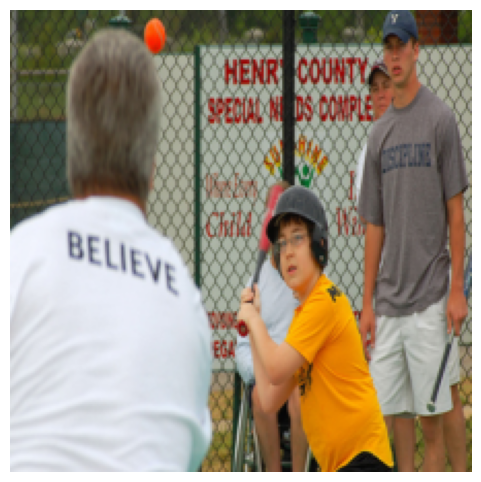

Generated Caption: two baseball players on the corner on each with walk

Actual Caption: A young boy is getting ready to hit a baseball .

Similarity Score: 0.0545



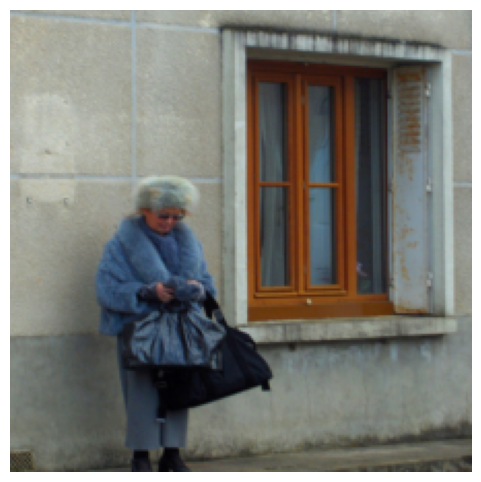

Generated Caption: a man wearing green jacket riding a window .

Actual Caption: A woman all dressed in blue with blue bags stands outside a window .

Similarity Score: 0.0610



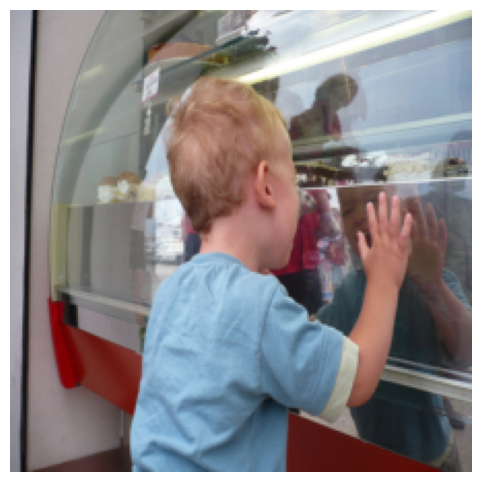

Generated Caption: a young lady and woman sitting up a couch of a glass boat .

Actual Caption: A little boy puts his face up to the uniquely-shaped window .

Similarity Score: 0.0507



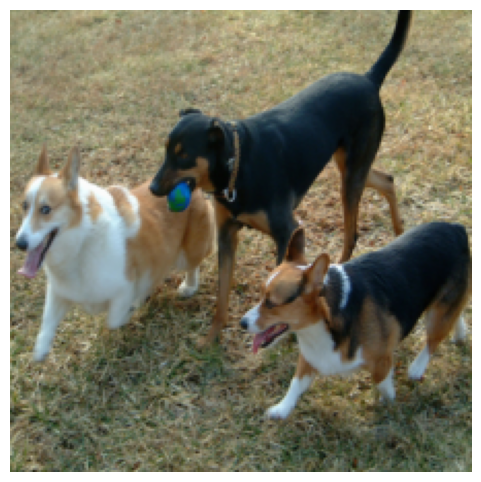

Generated Caption: a small dog running at a black dog .

Actual Caption: A big black dog carries a blue ball while two Corgis run at his side .

Similarity Score: 0.2658



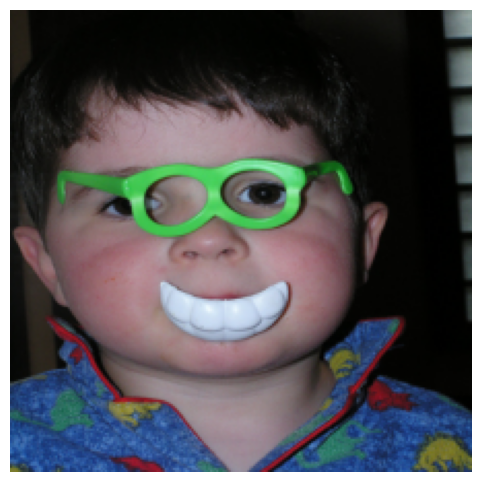

Generated Caption: the little girl is smiling and glasses and glasses with lips glasses sitting on her

Actual Caption: A little boy wears Mr. Potao head glasses and mouth .

Similarity Score: 0.2762



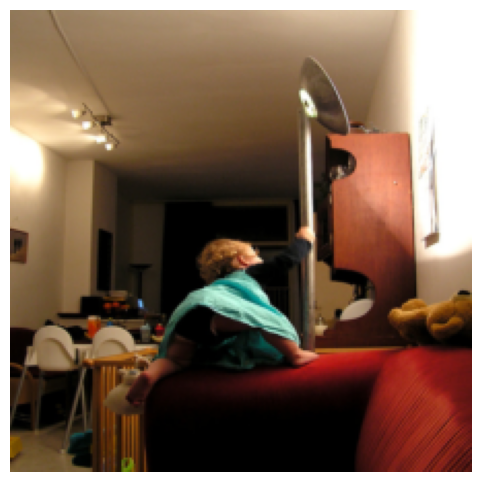

Generated Caption: two girls are at each other a museum and an <UNK> the male .

Actual Caption: A small child climbs onto the arm of a red couch .

Similarity Score: 0.0512



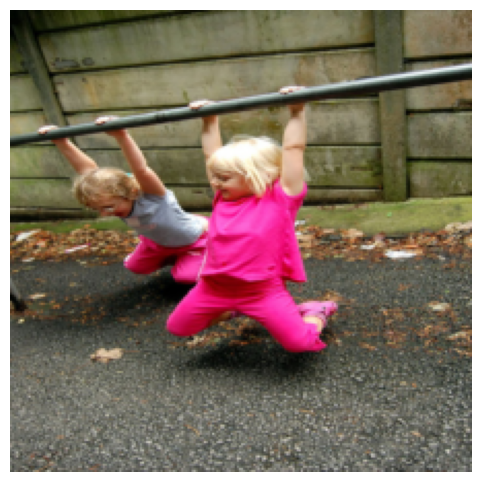

Generated Caption: the two girls playing in costume and jumping from their arms hanging on look over

Actual Caption: Two little girls hang on a bar in front of a wooden fence .

Similarity Score: 0.1868



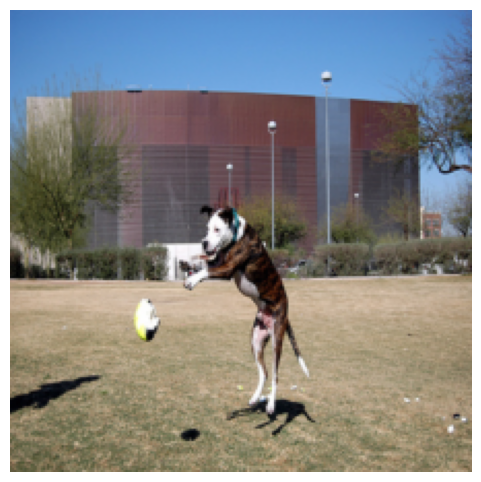

Generated Caption: dogs playing in a tennis ball .

Actual Caption: A dog jumps to catch a ball in a large field .

Similarity Score: 0.1909



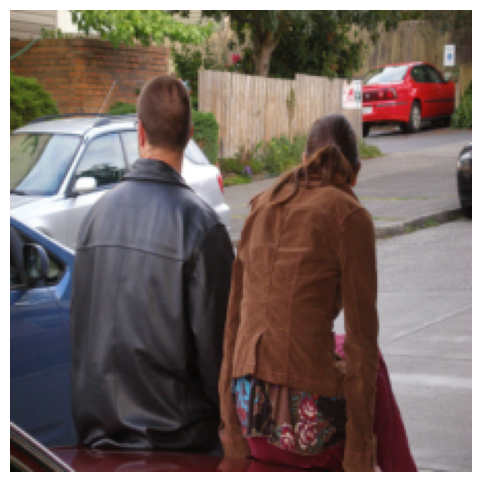

Generated Caption: a man sitting on wooden street while a man .

Actual Caption: A couple sits on a car .

Similarity Score: 0.0927



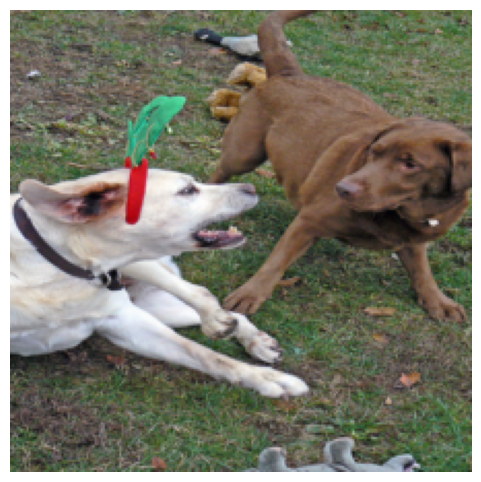

Generated Caption: a brown dog chasing a brown dog splashing with its ears on the camera of

Actual Caption: A white dog with fake antlers on its head and a brown dog play together outdoors .

Similarity Score: 0.3859



In [9]:
# ----------------------------
# 9. Inference
# ----------------------------
caption_model.eval()
feature_extractor.eval()

vectorizer = TfidfVectorizer()
selected_indices = random.sample(range(len(dataset)), 10)
selected_images = [dataset[i] for i in selected_indices]

for image, actual_captions in selected_images:
    image_tensor = image.unsqueeze(0).to(device)
    features = feature_extractor(image_tensor)

    caption = [2]  # <SOS>
    for _ in range(15):
        input_seq = torch.tensor(caption, device=device).unsqueeze(0)
        output = caption_model(features, input_seq)
        probs = torch.softmax(output[:, -1, :], dim=-1).squeeze(0)
        next_word = torch.multinomial(probs, 1).item()
        if next_word == 3:  # <EOS>
            break
        caption.append(next_word)

    generated_caption = " ".join([dataset.dataset.idx_to_word.get(idx, "<UNK>") for idx in caption[1:]])
    actual_caption_text = random.choice(actual_captions)

    tfidf_matrix = vectorizer.fit_transform([generated_caption, actual_caption_text])
    similarity_score = (tfidf_matrix * tfidf_matrix.T).toarray()[0, 1]

    plt.figure(figsize=(6, 6))
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()
    print(f"Generated Caption: {generated_caption}\n")
    print(f"Actual Caption: {actual_caption_text}\n")
    print(f"Similarity Score: {similarity_score:.4f}\n")